# GPU programming using PyOpenCL, part 4: Reduction

This is a set of exercises on the usage of PyOpenCL. There are 6 main classes of parallel algorithms:
1. Map or Element-wise kernels: 1 thread calculates 1 result from 1 input position
2. Gather: 1 thread calculates 1 result from several input data, one typical example is the convolution
3. Scatter: 1 thread uses 1 input element and scatters it on one or several output pixels, this requires the usage of atomic operarions
4. Reduction: Apply the same associative operation on all element of an ensemble, for example the sum of all elements in a list.
5. Scan: also called prefix sum, this algorithm applies the same associative operation to all *previous* elements of a list, for example a cummulative sum (cumsum)
6. Sort: using sorting network like the bitonic sort.

This fourth tutorial focuses on the **Reduction** operation where one applies the same associative operation to all element of the input array. 
The result is a single element, thus the name: reduction !

While reduction could be performed using *atomic_add*, this is not eficient as there are lots of write conflicts. Instead, the work is divided between threads and workgroups:

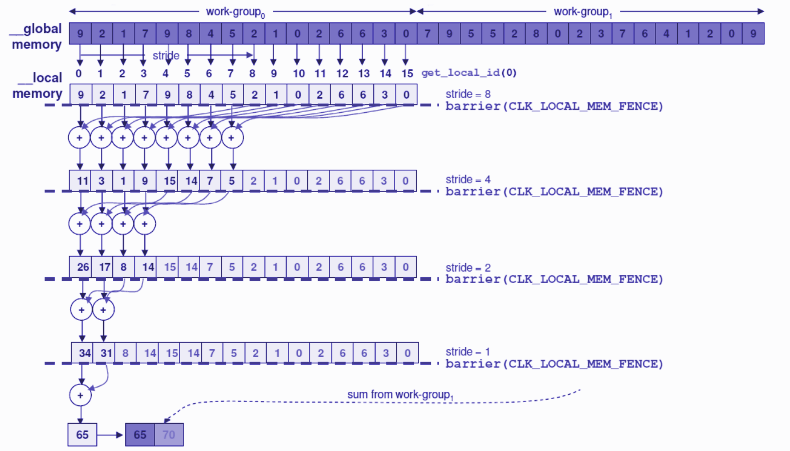

Like this, the number of operation to perform is still $O(n)$ like in sequential but the number of clock cycle is proportionnal to $O(log_2(n))$, thus much faster.

First we load some python modules to be able to read and display images. Then we initialize OpenCL, a context, a command queue, ...

We will first demonstrate the result in simple case where a kernel consists of a single, large workgroup. Nvidia hardware accept up to 1024 thread per workgroup (minimum reasonnable value: 32)

In [15]:
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"]="1"
#os.environ["PYOPENCL_CTX"]="Intel"
os.environ["PYOPENCL_CTX"]="Nvidia"
from math import ceil
import numpy as np
import pyopencl as cl
from pyopencl import array as cla

ctx = cl.create_some_context(interactive=False)
queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)

print(ctx.devices[0])
%load_ext pyopencl.ipython_ext

<pyopencl.Device 'NVIDIA RTX A5000' on 'NVIDIA CUDA' at 0x55acbfbda460>
The pyopencl.ipython_ext extension is already loaded. To reload it, use:
  %reload_ext pyopencl.ipython_ext


In [16]:
N = 1<<11
print(N)
data = np.random.randint(1, 100, size=N).astype("int32")
data_d = cla.to_device(queue, data)
data

2048


array([16,  5, 49, ..., 47, 34,  2], dtype=int32)

In [17]:
%%cl_kernel
kernel void sum_v1(global volatile int* data, int size)
{
    int tid = get_local_id(0);
    for (int stride = size/2; stride>0; stride/=2)
    {
        if ((tid+stride)<size) 
        {
            data[tid] += data[tid+stride];
        }
        barrier(CLK_GLOBAL_MEM_FENCE);
    }
}

In [18]:
data_d = cla.to_device(queue, data)
evt = sum_v1(queue, (1024,), (1024,),
             data_d.data, np.int32(N))
evt.wait()
print(f"Profile time: {(evt.profile.end-evt.profile.start)*1e-6:.3f}ms")
assert data_d[0] == data.sum()
data_d[:4], data.sum()

Profile time: 0.019ms


(cl.Array([102158, 102142, 102137, 102088], dtype=int32), np.int64(102158))

### Usage of local memory

To boost the performances, those operations should be performed in local memory (or shared memory).
This type of memory is only available from the treads within the same work-group.
It can be decalred either in a static way in the kernel like this:

```
local int shm[1024];
```

Either dynamically and passed as argument in the signature of the function:
```
shm = pyopencl.LocalMemory(size)

%%cl_kernel
kernel void sum_local(global int* data, int size, local int* shm){}
```

One can never allocate local memory from the kernel itself. 
One option is also to use built-time constant values and use the `-DValue=1024` option passed to the compiler.

This memory is very fast access (~3 cyles) vs 300 cycles for global memory. It is nevertheless slightly slower then register (1 cycle) and limited in size (max ~100kB).
Since several threads are accessing it, it is often usefull to declare this memory "volitile", i.e. threads should not make local caches of those values.


In [19]:
%%cl_kernel
kernel void sum_v2(global int* data, int size)
{
    int tid = get_local_id(0);
    int wg = get_local_size(0);
    
    // Populate the local memory with the data
    local volatile int data_local[1024]; // <= declaration of shared memory
    data_local[tid] = 0;
    for (int i=tid; i<size; i+=wg)
        data_local[tid] +=  data[i];

    //Perform the reduction
    barrier(CLK_LOCAL_MEM_FENCE);
    for (int stride = size/2; stride>0; stride/=2)
    {
        if ((tid+stride)<1024) 
        {
            data_local[tid] += data_local[tid+stride];
        }
        barrier(CLK_LOCAL_MEM_FENCE);
    }

    // Finally copy back the result

    data[tid] =  data_local[tid];
}

In [20]:
data_d = cla.to_device(queue, data)
evt = sum_v2(queue, (1024,), (1024,),
             data_d.data, np.int32(N))
evt.wait()
print(f"Profile time: {(evt.profile.end-evt.profile.start)*1e-6:.3f}ms")
assert(data_d.get()[0] == data.sum(dtype="int32"))

Profile time: 0.015ms


In order to process larger arrays one could:
1. use a 2-stage reduction, with *stage1* reducing the number of values from N²->N and *stage2* reducing N->1
2. Use a *stage0* which sums the values.

In [21]:
N = 1024
data = np.random.randint(1, 100, size=N**2).astype("int32")
%timeit data.sum()

286 µs ± 617 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
%%cl_kernel
kernel void sum_staged(global int* data, int size, global int* reduced)
{
    int gid = get_global_id(0);
    int tid = get_local_id(0);
    int wg = get_local_size(0);
    int gs = get_global_size(0);

    // Populate the local memory with the data + stage0
    local volatile int data_local[1024]; // <= declaration of shared memory, here static, cannot be dynamic.
    int tmp_data = 0;
    for (int i=gid; i<size; i+=gs)
        tmp_data +=  data[i];
    data_local[tid] = tmp_data;

    //Perform the reduction
    barrier(CLK_LOCAL_MEM_FENCE);
    for (int stride = wg/2; stride>0; stride/=2)
    {
        if ((tid+stride)<wg) 
        {
            data_local[tid] += data_local[tid+stride];
        }
        barrier(CLK_LOCAL_MEM_FENCE);
    }

    // Finally copy back the result
    if (tid == 0) reduced[get_group_id(0)] =  data_local[0];
}

In [23]:
data_d = cla.to_device(queue, data)
work1_d = cla.empty(queue, N, "int32")
work2_d = cla.empty(queue, 1, "int32")
evt1 = sum_staged(queue, (N*N,), (N,),
                  data_d.data, np.int32(N*N), work1_d.data)
# evt1.wait()
evt2 = sum_staged(queue, (N,), (N,),
                  work1_d.data, np.int32(N), work2_d.data)

evt2.wait()
print(f"Profile time: {(evt2.profile.end-evt1.profile.start)*1e-6:.3f}ms")
assert work2_d.get()[0] == data.sum(dtype="int32")

Profile time: 0.164ms


AssertionError: 

In [24]:
assert np.allclose(work1_d.get(),data.reshape((1024, 1024)).sum(axis=-1))
assert work2_d.get()[0] == data.sum(dtype="int32")

AssertionError: 

Writing a reduction kernel is fairly complicated and error prone ... this is why metaprogramming is interesting !
## Metprogramming reduction:

In [25]:
from pyopencl.reduction import ReductionKernel
ReductionKernel?

Init signature:
ReductionKernel(
    ctx: pyopencl._cl.Context,
    dtype_out: Any,
    neutral: str,
    reduce_expr: str,
    map_expr: Optional[str] = None,
    arguments: Union[str, List[pyopencl.tools.DtypedArgument], NoneType] = None,
    name: str = 'reduce_kernel',
    options: Any = None,
    preamble: str = '',
) -> None
Docstring:     
A kernel that performs a generic reduction on arrays.

Generate a kernel that takes a number of scalar or vector *arguments*
(at least one vector argument), performs the *map_expr* on each entry of
the vector argument and then the *reduce_expr* on the outcome of that.
*neutral* serves as an initial value. *preamble* offers the possibility
to add preprocessor directives and other code (such as helper functions)
to be added before the actual reduction kernel code.

Vectors in *map_expr* should be indexed by the variable *i*. *reduce_expr*
uses the formal values "a" and "b" to indicate two operands of a binary
reduction operation. If you do not s

In [26]:
sum_d = ReductionKernel(ctx, 
                        np.int32, 
                        neutral="0",
                        map_expr="x[i]",
                        reduce_expr="a+b", 
                        arguments="__global int* x")
%timeit sum_d(data_d).get()
%timeit data.sum()
assert sum_d(data_d).get() == data.sum()

143 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
288 µs ± 90.3 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


GPU are faster but only to the limit of the bandwidth, since there is hardly any computing here.

## More challenging example: min/max in a single pass

OpenCL offers vectorial type like *float2* which groups 2 float32 ... see the OpenCL cheat-sheet.
With this, one can calculate in a single pass both the maximum and the minimum of all elements in an array.

In [41]:
size = 1<<24
print(size)
ary = np.random.random(size).astype("float32")
dtype = np.dtype([("mini", np.float32), ("maxi", np.float32),])
from pyopencl.tools import get_or_register_dtype, match_dtype_to_c_struct
dtype, ctype = match_dtype_to_c_struct(ctx.devices[0], "minmax_t", dtype)
print(dtype)
print(ctype)
dtype = get_or_register_dtype("minmax_t", dtype)

16777216
[('mini', '<f4'), ('maxi', '<f4')]
typedef struct {
  float mini;
  float maxi;
} minmax_t;




In [43]:
preamble = """
typedef struct {
  float mini;
  float maxi;
} minmax_t;

minmax_t neutral()
    {
        minmax_t result;
        result.mini = +MAXFLOAT;
        result.maxi = -MAXFLOAT;
        return result;
    }

minmax_t map(float x){
    minmax_t result;
    result.mini = x;
    result.maxi = x;
    return result;
}

minmax_t aggregate(minmax_t a, minmax_t b)
    {
        minmax_t result = a;
        if (b.mini < result.mini)
            result.mini = b.mini;
        if (b.maxi > result.maxi)
            result.maxi = b.maxi;
        return result;
    }

"""
minmax_k = ReductionKernel(ctx, 
                           dtype, 
                           neutral="neutral()",
                           map_expr="map(x[i])",
                           reduce_expr="aggregate(a, b)", 
                           arguments="__global float* x",
                           preamble = preamble)


In [46]:
ary_d = cla.to_device(queue, ary)
%timeit minmax_k(ary_d)
%timeit (ary.min(),ary.max())

239 µs ± 876 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
5.22 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Now it is your turn: Dot product

Write a function calculating the dot-product between 2 vectors using the Reduction kernel and spacially crafted *map* expression

In [48]:
a = np.arange(4000, dtype=np.float32)
b = np.arange(4000, dtype=np.float32)

a_d = cla.to_device(queue, a)
b_d = cla.to_device(queue, b)

# dot_k = ReductionKernel(ctx, ... )

# assert dot_k(a, b).get() == np.dot(a,b)

Correction: see example in pyopencl's documentation.

## Advanced exercise: (optional)

Write a kernel which takes an image and subtracts from each element the mean calculated per line.


In [49]:
shape = 1440, 2560
# img = np.random.random(size=shape).astype("float32")
img = np.arange(np.prod(shape)).astype("float32").reshape(shape)
ref = img - img.mean(axis=-1)[:, np.newaxis]
%timeit img - img.mean(axis=-1)[:, np.newaxis]

2.32 ms ± 4.84 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


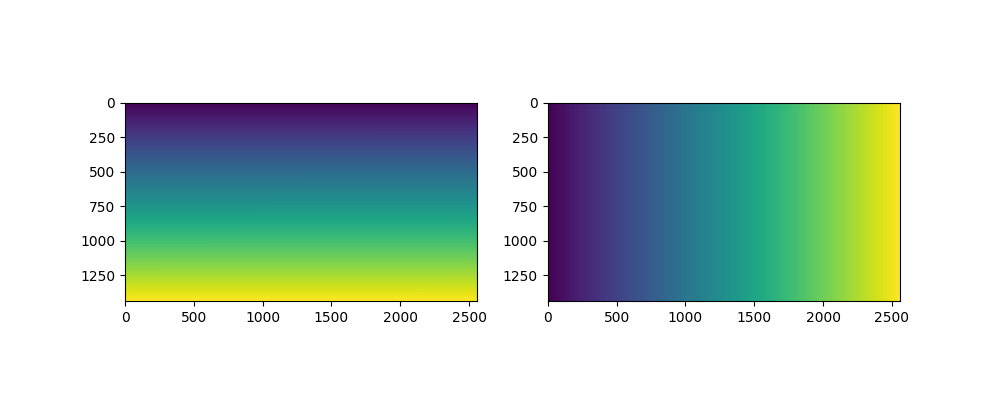

In [50]:
%matplotlib widget
from matplotlib.pyplot import subplots
fig,ax = subplots(1, 2, figsize=(10,4))
ax[0].imshow(img)
ax[1].imshow(ref)

In [51]:
%%cl_kernel

// Correction, don't look !

kernel void sub_mean(global float* img,
                     global float* res,
                            int height, 
                            int width)
{
    int x, y, tid, wg, r, stride, width_local, i;
    x = get_global_id(0);
    y = get_global_id(1);
    tid = get_local_id(0);
    wg = get_local_size(0);
    local volatile float shared[1024];
    width_local = min(1024, width);
    shared[tid] = 0.0f;

    if (y<height)
    {
        r = y*width;
        for (i=tid; i<width; i+=wg)
            shared[tid] += img[r + i];
        barrier(CLK_LOCAL_MEM_FENCE);
        
        for (stride = 512; stride>0; stride/=2){
            if ((tid + stride) < width_local)
                shared[tid] += shared[tid + stride];
            barrier(CLK_LOCAL_MEM_FENCE);
        }
        // map operation
        float mean = shared[0]/width;
        for (i=tid; i<width; i+=wg)
            res[r+i] = img[r + i] - mean;
    }        
}

In [78]:
img_d = cla.to_device(queue, img)
res_d = cla.empty_like(img_d)
wg = (1024, 1)
grid = (ceil(shape[-1]/wg[0])*wg[0], shape[0])
print(grid)
evt = sub_mean(queue, grid, wg,
              img_d.data, res_d.data, np.int32(shape[0]), np.int32(shape[1]));
evt.wait()
print(f"Profile time: {(evt.profile.end-evt.profile.start)*1e-6:.3f}ms")
assert np.allclose(res_d.get(), ref, atol=0.3)
# print((res_d.get()-ref).min())


(3072, 1440)
Profile time: 3.959ms
True
